# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [32]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, cartesian2polar

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, makeNestedPlotDirectory

import seaborn as sns 
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()


# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)')
expDir = expDir + sep

analysisDir = sep.join(expDir.split(sep)[:-2]) + sep + 'analysis' + sep
try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')
    
dataDir =  sep.join(expDir.split(sep)[:-2]) + sep

try:
    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/datafiles')
    exit(1)

print('\n Analysing the following files:\n')

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')

Analysis directory already exists.

 Analysing the following files:

Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [33]:
FODataFiles = FODataFiles[:]
FODataFiles

['Stripe7_BlackOnWhite_DL_f01_out_160728160611.txt',
 'Stripe7_BlackOnWhite_DL_f02_out_160728162249.txt',
 'Stripe7_BlackOnWhite_DL_f03_out_160728171608.txt',
 'Stripe7_BlackOnWhite_DL_f04_out_160728195604.txt',
 'Stripe7_BlackOnWhite_DL_f05_out_160728200902.txt',
 'Stripe7_BlackOnWhite_DL_f06_out_160728202151.txt',
 'Stripe7_BlackOnWhite_DL_f07_out_160728203514.txt',
 'Stripe7_BlackOnWhite_DL_f08_out_160728205118.txt',
 'Stripe7_BlackOnWhite_DL_f09_out_160728210315.txt',
 'Stripe7_BlackOnWhite_DL_f10_out_160728211610.txt']

### Compose mutli-fly data into dataframe

In [34]:
# generate fly color map

numFlies = len(FODataFiles[:])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [35]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [36]:
# TODO: move into separate .py file that can be loaded in header...

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme
from velocityDistributionPlots import velocitySummaryPlot

def processStripetrackingTrial(experimentDir, logFile, dataDir):
    
    # Load FlyOver log file, extract calibration paramater and name of cood file
    
    header, FOData, numFrames, frameRange, calibParams, coordFile = loadSingleVRLogfile(experimentDir, logFile)
    
    # Read in object coordinates
    
    visObjCoords, visObjName, invisObjCoords, origin = loadObjectCoordIdentities(dataDir, coordFile)
    
    # Compute derrived values
    
    ## Compute movement velocities
    logTime = np.copy(FOData[:, 0])
    time = np.linspace(0, logTime[-1], numFrames)

    angle = convertRawHeadingAngle(FOData[:, 5])
    
    # Compute fly's walking velocieties from TM raw values
    
    dx1 = FOData[:,6]
    dy1 = FOData[:,7]
    dx2 = FOData[:,8]
    dy2 = FOData[:,9]
    
    dtime = np.diff(time)
    dtime = np.hstack((dtime[0],dtime))
    
    ## parameter definitions
    gammaRad = 45*np.pi/180; #absolute angle of cameras to longitudinal axis (of fly)
    rBall = float(calibParams[0])
    pixel2mm = 0.013514

    conversionFactor_pitch = (1.0/pixel2mm)*float(calibParams[0])*2.0*(np.pi/2.0)*(1.0/float(calibParams[1]))
    conversionFactor_yaw = (1.0/pixel2mm)*float(calibParams[0])*2.0*(np.pi/2.0)*(1.0/float(calibParams[2]))

    ## compute virtual rotation of fly
    vFwdBall = - (dy1 + dy2) * np.cos(gammaRad); #add components along longitudinal axis
    vSideBall = - (dy1 - dy2) * np.sin(gammaRad); #add components along transversal axis
    vRotBall = - (dx1 + dx2)/2 #average measured displacement along aximuth

    ## convert A.U. --> pixel --> mm
    vFwdBall = pixel2mm * vFwdBall * conversionFactor_pitch # use scaling factor for pitch
    vSideBall = pixel2mm * vSideBall * ((conversionFactor_yaw + conversionFactor_pitch)/2) #use mean
    vRotBall = pixel2mm * vRotBall * conversionFactor_yaw # use scaling factor for yaw

    ## convert to mm/s
    vFwdBall = vFwdBall / dtime
    vSideBall = vSideBall / dtime
    vRotBall =  vRotBall / dtime

    vRot = - vRotBall / rBall #mm/s to deg/s

    ## Assume initial position (0 0 0) = (x-coord, y-coord, angle): 
    ## --> fly in origin, aligned with x axis (head forward)
    ## During measurement coordinate system is fly-centered, moves with fly.
    ## Compute all changes along those axes by updating angle and
    ## projecting the position changes onto the fixed coordinate system

    angle = np.cumsum(vRot * dtime)
    angle = np.mod((angle + np.pi),2*np.pi) - np.pi

    ## movement in x and y direction
    yTM_i = vSideBall * np.cos(-angle) - vFwdBall * np.sin(-angle) #compute increments x_i
    yPos = np.cumsum(yTM_i* dtime) # integrate x_i to get path

    xTM_i = vSideBall * np.sin(-angle) + vFwdBall * np.cos(-angle)
    xPos = np.cumsum(xTM_i * dtime)

    vTrans = np.hypot(xTM_i, yTM_i)
    
    # Downsample
    
    ## Down sample data to 20 Hz
    samplingRate = 20
    time_ds, xPos_ds, yPos_ds, angle_ds, numFrames_ds \
        = donwsampleFOData(samplingRate, logTime, time, xPos, yPos, angle)

    ## and compute downsampled velocities
    N = 5
    vTrans_ds, vRot_ds, vTransFilt_ds, vRotFilt_ds \
        = velocityFromTrajectory(time_ds, angle_ds, xPos_ds, yPos_ds, N, numFrames_ds)

    ## Classify time point as 'moving' or 'non-moving' based on transl. velocity
    vTransTH = 2.0
    moving = vTrans_ds > vTransTH
    
    ## Compute relative heading
    gamma = abs(angle_ds)
    gammaFull = angle_ds
        
    # Generate basic processing plots
    
    ## Time step plot
    tstpfig = plt.figure(figsize = (10,3))
    gs = gridspec.GridSpec(1,2,width_ratios=np.hstack((2,1)))
    tstpfig.suptitle( titleString, fontsize = 13)

    histRange = (0,0.011)

    ax = tstpfig.add_subplot(gs[0])
    ax.plot(FOData[0:-2,0],(FOData[1:-1,0]-FOData[0:-2,0]).astype('float'),'.', alpha = 0.1)
    ax.set_ylim(histRange)
    ax.set_xlim((0,time[-1]))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('time step [1/s]')
    myAxisTheme(ax)

    ax = tstpfig.add_subplot(gs[1])
    ax.hist(FOData[1:-1,0]-FOData[0:-2,0],50,histRange)
    ax.set_xlabel('time step [1/s]')
    ax.set_ylabel('count')
    ax.set_title('mean time step = ' + str(round(np.mean((FOData[1:-1,0]-FOData[0:-2,0])*1000.0),2)) + 'ms' )
    myAxisTheme(ax)

    tstpfig.tight_layout()

    try:
        mkdir(dataDir + 'analysis/timeStepPlot/')
    except OSError:
        print('Plot directory already exists.')

    tstpfig.savefig(dataDir + 'analysis/timeStepPlot/' + fileToAnalyse [0:-4] + '_timeStepPlot.pdf', format = 'pdf')
    
    ## Plot velocity distributions of downsampled data
    rotLim = (-5, 5)
    transLim = (0, 30)
    angleLim = (-np.pi, np.pi)
    summaryVeloFig_ds = velocitySummaryPlot(time_ds, vTrans_ds, vTransFilt_ds, vRot_ds, vRotFilt_ds, angle_ds,\
                                            rotLim, transLim, angleLim, \
                                            'Downsampled and filtered downsampled velocity traces, ' + titleString)

    try:
        mkdir(dataDir + 'analysis/velocityTraces/')
    except OSError:
        print('Plot directory already exists.')

    summaryVeloFig_ds.savefig(dataDir + 'analysis/velocityTraces/' + fileToAnalyse [0:-4] + '_veloTraces_ds.pdf',\
                              format = 'pdf')
    
    ## Heading angle distribution
    headingfig = plt.figure(figsize=(10,8))

    gammaPlt = headingfig.add_subplot(221)
    histRange = (0, np.pi)
    nhead, edges = np.histogram(gamma[moving>0],density=True,range=histRange,bins=18)
    normFactor = nhead.sum()
    gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor)
    gammaPlt.set_xlim(histRange)
    gammaPlt.set_xlabel('rel. heading')
    gammaPlt.set_ylabel('frequency (when moving)')
    myAxisTheme(gammaPlt)

    gammaFullPlt = headingfig.add_subplot(222)
    histRange = (-np.pi, np.pi)
    nhead, edges = np.histogram(gammaFull[moving>0],density=True,range=histRange,bins=36)
    normFactor = nhead.sum()
    gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor)
    gammaFullPlt.set_xlim(histRange)
    gammaFullPlt.set_xlabel('rel. heading (full)')
    myAxisTheme(gammaFullPlt)

    gammaPlt = headingfig.add_subplot(223)
    histRange = (0, np.pi)
    nhead, edges = np.histogram(gamma,density=True,range=histRange,bins=18)
    normFactor = nhead.sum()
    gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color='grey')
    gammaPlt.set_xlim(histRange)
    gammaPlt.set_xlabel('rel. heading')
    gammaPlt.set_ylabel('frequency')
    myAxisTheme(gammaPlt)

    gammaFullPlt = headingfig.add_subplot(224)
    histRange = (-np.pi, np.pi)
    nhead, edges = np.histogram(gammaFull,density=True,range=histRange,bins=36)
    normFactor = nhead.sum()
    gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color='grey')
    gammaFullPlt.set_xlim(histRange)
    gammaFullPlt.set_xlabel('rel. heading (full)')
    myAxisTheme(gammaFullPlt)


    headingfig.suptitle(titleString,fontsize=13)

    headingfig.tight_layout

    try:
        mkdir(dataDir + 'analysis/heading/')
    except OSError:
        print('Plot directory already exists.')

    headingfig.savefig(dataDir + 'analysis/heading/' + fileToAnalyse [0:-4] + '_headingDistribution.pdf', format = 'pdf')

    
    # Save values for future analysis
    
    xPosMA_ds = np.nan*np.ones(np.size(time_ds))
    yPosMA_ds = np.nan*np.ones(np.size(time_ds))

    toSave = {'time': time_ds,
              'xPos': xPos_ds,
              'yPos': yPos_ds,
              'xPosInMiniarena': xPosMA_ds,
              'yPosInMiniarena': yPosMA_ds,
              'headingAngle': angle_ds,
              'rotVelo': vRot_ds,
              'transVelo': vTrans_ds,
              'gammaFull': gammaFull,
              'gamma': gamma,
              'moving': moving}

    np.save(expDir + fileToAnalyse [:-4], toSave)

In [37]:
#vTransTH = 2 #mm/s

# Run single trial analysis from each fly in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log files:\n')
    print(fileToAnalyse)
    
    dataFileParts = fileToAnalyse.split('_')
    genotype = dataFileParts[2]
    sceneName = dataFileParts[0] + dataFileParts[1]
    flyID = dataFileParts[3]
    titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'
    print(titleString)

    trial = 1

    if rerunbasicanalysis == 'y':
        #Load and process raw data
        processStripetrackingTrial(expDir, fileToAnalyse, dataDir)
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        print('Ran analysis, now loading saved *.npy file.')
    else:
        # just load existing npy file with processed data
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        print('Loading saved *.npy file.')

    trialtype = 'stripe'
    
    if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
        sceneName = 'inverted'+sceneName

    # add to data frame
    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'sceneName', sceneName)


    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)

    # TODO: Add selection criteria, e.g. to only include trials from flies that were 
    # walking >40% of time and did not have a strong turn bias.



 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f01_out_160728160611.txt
fly f01 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f02_out_160728162249.txt
fly f02 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f03_out_160728171608.txt
fly f03 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f04_out_160728195604.txt
fly f04 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f05_out_160728200902.txt
fly f05 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f06_out_160728202151.txt
fly f06 (DL) in Stripe7BlackOnWhite world
Loading saved *.npy file.

 Analysing the following log files:

Stripe7_BlackOnWhite_DL_f07_out_

In [38]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,sceneName,gamma,gammaFull,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,moving
0,f01,1.0,stripe,Stripe7BlackOnWhite,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.0
1,f01,1.0,stripe,Stripe7BlackOnWhite,0.000000,0.000000,0.000000,0.000000,0.050009,0.000000,0.000000,NaN,0.000000,NaN,0.0
2,f01,1.0,stripe,Stripe7BlackOnWhite,0.000000,0.000000,0.000000,0.000000,0.100017,0.000000,0.000000,NaN,0.000000,NaN,0.0
3,f01,1.0,stripe,Stripe7BlackOnWhite,0.000000,0.000000,0.000000,0.000000,0.150026,0.000000,0.000000,NaN,0.000000,NaN,0.0
4,f01,1.0,stripe,Stripe7BlackOnWhite,0.000000,0.000000,0.000000,-0.079120,0.200035,0.000000,0.000000,NaN,0.000000,NaN,0.0
5,f01,1.0,stripe,Stripe7BlackOnWhite,0.003957,-0.003957,-0.003957,-0.158239,0.250043,0.755333,0.000000,NaN,0.000000,NaN,0.0
6,f01,1.0,stripe,Stripe7BlackOnWhite,0.011870,-0.011870,-0.011870,0.000000,0.300052,0.000000,-0.027374,NaN,-0.026028,NaN,0.0
7,f01,1.0,stripe,Stripe7BlackOnWhite,0.011870,-0.011870,-0.011870,0.000000,0.350061,0.000000,-0.027374,NaN,-0.026028,NaN,0.0
8,f01,1.0,stripe,Stripe7BlackOnWhite,0.011870,-0.011870,-0.011870,0.000000,0.400069,0.000000,-0.027374,NaN,-0.026028,NaN,0.0
9,f01,1.0,stripe,Stripe7BlackOnWhite,0.011870,-0.011870,-0.011870,-0.079120,0.450078,0.000000,-0.027374,NaN,-0.026028,NaN,0.0


In [39]:
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

genotypeSex = fileToAnalyse.split('_')[1][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Experimental conditions

In [40]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))
sceneNames

['Stripe7BlackOnWhite']

#### Heading angle distribution (if stripe)

In [41]:
genotypeSex = fileToAnalyse.split('_')[2]+fileToAnalyse.split('_')[-4][0]
genotypeSex

'DLD'

In [42]:
def plotHeadingComparison(sceneName,titleString,densityFlag,plotIQR):
    legendlist = []
    halfBins = 18
    fullBins = 36
    
    nhead_halfGamma = np.nan*np.ones((numFlies,halfBins,2))
    nhead_fullGamma = np.nan*np.ones((numFlies,fullBins,2))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze()
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving')
            print(100.0*sum(moving)/max(1,len(moving)))
            
            continue
            
        legendlist.append(flyIDs[fly])

        gammaPlt = headingfig.add_subplot(221)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
            normFactor = nhead.sum()
        else:
            gammaPlt.set_ylabel('count (when moving)')
            normFactor = 1.0
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        myAxisTheme(gammaPlt)
        
        nhead_halfGamma[fly,:,0] = nhead/normFactor
        halfedges = edges[:-1]+np.diff(edges)/2

        gammaFullPlt = headingfig.add_subplot(222)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        if densityFlag:
            normFactor = nhead.sum()
        else:
            normFactor = 1.0
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt)
        
        nhead_fullGamma[fly,:,0] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        gammaPlt2 = headingfig.add_subplot(223)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt2.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt2.set_ylabel('frequency (when standing)')
            normFactor = nhead.sum()
        else:
            gammaPlt2.set_ylabel('count (when standing)')
            normFactor = 1.0
        gammaPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaPlt2.set_xlim(histRange)
        myAxisTheme(gammaPlt2)
        
        nhead_halfGamma[fly,:,1] = nhead/normFactor

        gammaFullPlt2 = headingfig.add_subplot(224)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaFullPlt2.set_xlim(histRange)
        gammaFullPlt2.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt2)
        
        nhead_fullGamma[fly,:,1] = nhead/normFactor

    headingfig.suptitle(titleString,fontsize=13)
    gammaFullPlt2.legend(legendlist)
    headingfig.tight_layout()
    
    gammaPlt.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,0],0),color='k',linewidth=3)
    gammaFullPlt.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,0],0),color='k',linewidth=3)
    
    gammaPlt2.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    gammaFullPlt2.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    
    if(plotIQR):
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,0],[25,75],axis=0)
        gammaPlt.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,0],[25,75],axis=0)
        gammaFullPlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,1],[25,75],axis=0)
        gammaPlt2.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,1],[25,75],axis=0)
        gammaFullPlt2.fill_between(fulledges, var1, var2, color='k', alpha=0.2)


    return headingfig, nhead_fullGamma[:,:,0]

In [43]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


In [44]:
numFlies

10

In [45]:
sceneName

'Stripe7BlackOnWhite'

Stripe7BlackOnWhite

fly f02 not moving
17.175
fly f05 not moving
15.1416666667


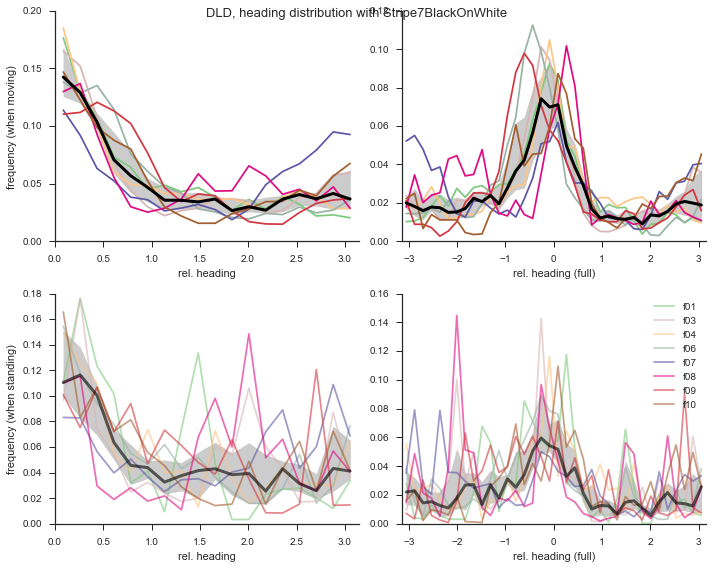

In [46]:
headingfig = plt.figure(figsize=(10,8))

print(sceneName+'\n')
densityFlag = True
titleString = genotypeSex+', heading distribution with '+ sceneName

headingfig, nhead_fullGamma = plotHeadingComparison(sceneName,titleString,densityFlag,True)

headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+sceneName+\
                   '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

np.savetxt(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+sceneName+\
                   '_n'+str(numFlies)+'.csv', nhead_fullGamma, delimiter=',')

Stripe7BlackOnWhite
fly f02 not moving
17.175
fly f05 not moving
15.1416666667


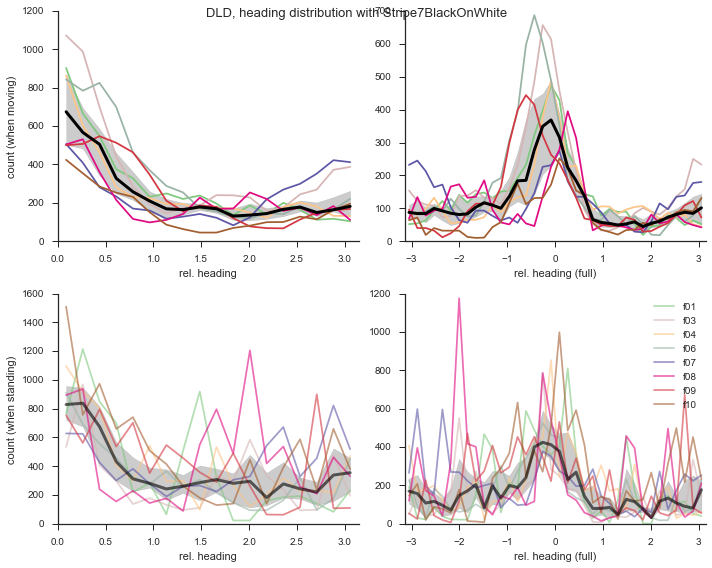

In [47]:
headingfig = plt.figure(figsize=(10,8))

print(sceneName)

densityFlag = False
titleString = genotypeSex+', heading distribution with '+ sceneName

headingfig, nhead_fullGamma = plotHeadingComparison(sceneName,titleString,densityFlag,True)

headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+sceneName+\
                   '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

np.savetxt(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+sceneName+\
                   '_n'+str(numFlies)+'.csv', nhead_fullGamma, delimiter=',')

## Compute circular statistics on heading distribution

In [48]:
# Modified function circmean from scipy.stats package. Added calculation of mean vector length

def _circfuncs_common(samples, high, low):
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.nan

    ang = (samples - low)*2*np.pi / (high - low)
    return samples, ang


def circmeanvec(samples, weights, high=2*np.pi, low=0, axis=None):
    """
    Compute the circular mean for samples in a range.
    Parameters
    ----------
    samples : array_like
        Input array.
    weights: array_like
        Input array with weights (i.e. vector lengths)
    high : float or int, optional
        High boundary for circular mean range.  Default is ``2*pi``.
    low : float or int, optional
        Low boundary for circular mean range.  Default is 0.
    axis : int, optional
        Axis along which means are computed.  The default is to compute
        the mean of the flattened array.
    Returns
    -------
    circmean : float
        Circular mean direction
        Ciruclar mean length
    """
    samples, ang = _circfuncs_common(samples, high, low)
    
    try:
        N = len(ang)
    except:
        print('problem with sample')
        print(samples)
        
        return np.nan, np.nan
        
    S = (weights*np.sin(ang)).sum(axis=axis)
    C = (weights*np.cos(ang)).sum(axis=axis)
    res = np.arctan2(S, C)
    mask = res < 0
    if mask.ndim > 0:
        res[mask] += 2*np.pi
    elif mask:
        res += 2*np.pi
    direction = res*(high - low)/2.0/np.pi + low
    
    length = np.sqrt( np.square(C) + np.square(S) )/len(weights)
    
    return direction, length

In [49]:
angleLow = -np.pi
angleHigh = np.pi

headingPVA = np.nan*np.ones((numFlies,3))

from scipy.stats import circmean as circmean
import csv
import datetime

#print('Timestamp: {:%Y%m%d-%H%M%S}'.format(datetime.datetime.now()))
timestp = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

fliesNotWalking = 0

for fly in range(len(flyIDs)):
    
    querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

    perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

    if sum(moving)<=0.2*len(moving):
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
        fliesNotWalking = fliesNotWalking+1

        continue
    gamFul = perFlyG[moving>0]
    meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

    headingPVA[fly,0] = meandir
    headingPVA[fly,1] = meanlen
    headingPVA[fly,2] = len(gamFul[~np.isnan(gamFul)])

try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
    
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_dir_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_len_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotypeSex + '_headingPVA_n_'+sceneName+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,2], delimiter=',')

fly f02 not moving: 17.175
fly f05 not moving: 15.1416666667
Analysis directory already exists.


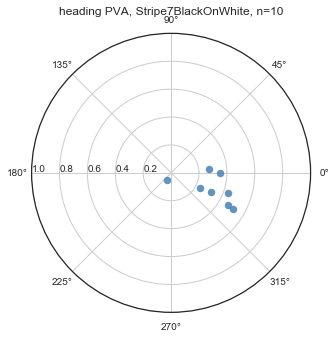

In [50]:
PVAFig = plt.figure(figsize=(5,5))

ax = PVAFig.add_subplot(111,projection='polar')
ax.plot(headingPVA[:,0],headingPVA[:,1],'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='black',alpha=1, markersize=10)
ax.set_rlim(0,1)
ax.set_rlabel_position(180)
ax.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))


PVAFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Rayleigh test

This test is powerful at finding deviations from non-unimodal distributions. -> Significance of the mean angle.
This test should be performed on heading frequencies, where the frequency observed in each bin is considered a sample, i.e. n = number of bins.

In [51]:
def RayleighTest(r,n):
    R = n*r
    
    #Rayleigh z
    z_R = n*np.square(r)
    
    #Rayleigh probability approximation
    p_R = np.exp(np.sqrt(1 + 4*n + 4*(np.square(n)-np.square(R))) - (1+2*n))
    
    return z_R, p_R

In [52]:
binwidth = 10
nBins = 360/binwidth

fly = 9

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values
perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
gamFul = perFlyG[moving>0]

#compute distribution
bins = np.linspace(-np.pi, np.pi, nBins+1)
alphaBins = bins[:-1] + np.mean(np.diff(bins))
[freq,edg] = np.histogram(gamFul,bins, normed=True)

PVAdir, PVAlen = circmeanvec(alphaBins,freq, high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,len(freq))

## Fit von Mises distribution

In [53]:
#import scipy
#scipy.__version__

In [54]:
from scipy import stats as sts
from scipy.optimize import curve_fit

def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

[ 0.12814436  0.20260204]


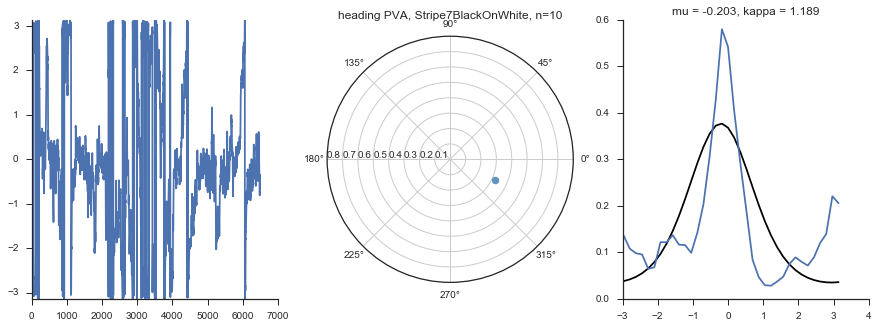

In [55]:
fly = 2
angleLow = -np.pi
angleHigh = np.pi

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0] #+ np.pi
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

fitFig = plt.figure(figsize=(15,5))
ax = fitFig.add_subplot(131)
ax.plot(gamFul)
ax.set_ylim(angleLow, angleHigh)
myAxisTheme(ax)
ax2 = fitFig.add_subplot(132,projection='polar')
ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax2.set_rlim(0,0.8)
ax2.set_rlabel_position(180)
ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu = popt[0]
kappa = popt[1]
yhat = vMFunc(x,mu,kappa)

ax = fitFig.add_subplot(133)
ax.plot(x,yhat,'k')
ax.plot(x,n)
ax.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax)


fly f02 not moving: 17.175
fly f05 not moving: 15.1416666667


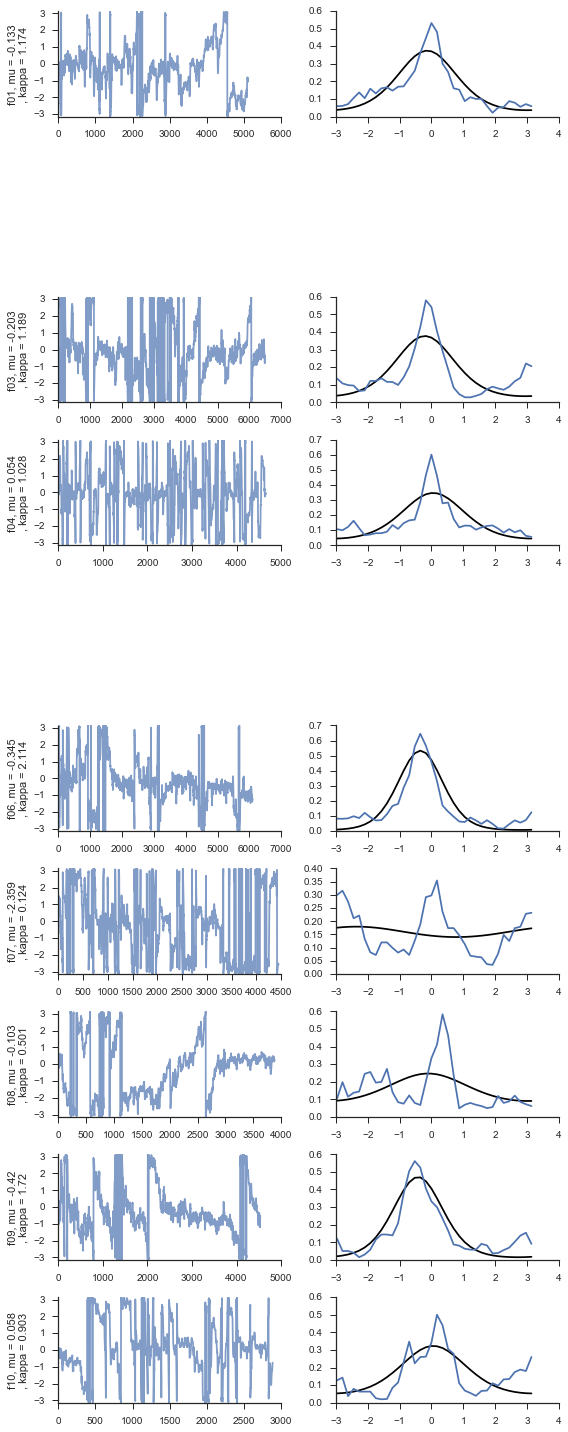

In [56]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 10 #deg

numFlies = len(flyIDs)

vmfits = np.nan*np.ones((5,numFlies))
fitFig = plt.figure(figsize=(8,2*numFlies))

for fly in range(numFlies):
    querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

    perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

    if sum(moving)<=0.2*len(moving):
        print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
        
        continue

    gamFul = perFlyG[moving>0]
    
    bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(gamFul,bins, normed=True)
    
    meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)
    
    popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
    mu = popt[0]
    kappa = popt[1]
    yhat = vMFunc(x,mu,kappa)
    
    #compute gof with chi square --> not appropriate for frequency distributions...
    #[cs, p] = sts.chisquare(n, f_exp=yhat,ddof=3)
    
    #compute kolmogorov-smirnov statistic as measure of goodness of fit
    [ks, p] = sts.ks_2samp(n, yhat)
    
    #compute squared difference from fit
    sqd = np.sum(np.square(n-yhat))
    
    vmfits[0,fly] = mu
    vmfits[1,fly] = kappa
    vmfits[2,fly] = sqd
    vmfits[3,fly] = p
    vmfits[4,fly] = ks
    
    #plot fit results
    ax = fitFig.add_subplot(numFlies,2,1+fly*2)
    ax.plot(gamFul,alpha=0.7)
    ax.set_ylim(angleLow,angleHigh)
    ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
    myAxisTheme(ax)

    ax = fitFig.add_subplot(numFlies,2,2+fly*2)
    ax.plot(x,yhat,'k')
    ax.plot(x,n)
    myAxisTheme(ax)

fitFig.tight_layout()

fitFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

flies with heading distribution that is significantly different from von Mieses fit (KS test):
['f06', 'f07', 'f08']
flies with large summed squared error:
['f01', 'f03', 'f04', 'f06', 'f07', 'f08', 'f09', 'f10']


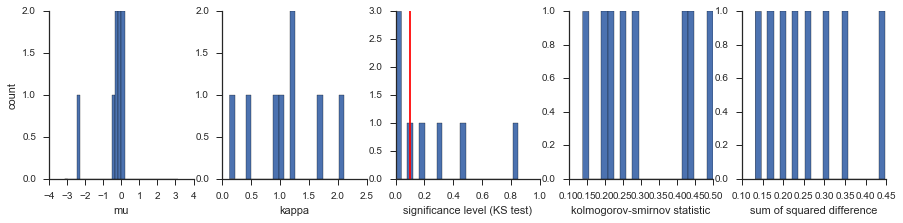

In [57]:
fitFig = plt.figure(figsize=(15,3))

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

muax = fitFig.add_subplot(151)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins)
#muax.set_xlim(-np.pi, np.pi)
muax.set_ylabel('count')
muax.set_xlabel('mu')
myAxisTheme(muax)

bins = np.linspace(0, 2, 21)
kapax = fitFig.add_subplot(152)
kapax.hist(vmfits[1,~np.isnan(vmfits[1,:])],len(bins))
#kapax.set_xlim(0, 2)
kapax.set_xlabel('kappa')
myAxisTheme(kapax)

bins = np.linspace(0, 1, 21)
pax = fitFig.add_subplot(153)
pax.hist(vmfits[3,~np.isnan(vmfits[3,:])],len(bins))
pax.set_xlim(0, 1)
pax.axvline(0.1,color='red')
pax.set_xlabel('significance level (KS test)')

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(154)
ksax.hist(vmfits[4,~np.isnan(vmfits[4,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('kolmogorov-smirnov statistic')
myAxisTheme(ksax)

bins = np.linspace(0, 1, 21)
ksax = fitFig.add_subplot(155)
ksax.hist(vmfits[2,~np.isnan(vmfits[2,:])],len(bins))
#ksax.set_xlim(0, 1)
ksax.set_xlabel('sum of squared difference')
myAxisTheme(ksax)

print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
print([flyIDs[fly] for fly in np.where(vmfits[3,:]<=0.1)[0]])

print('flies with large summed squared error:')
print([flyIDs[fly] for fly in np.where(vmfits[2,:]>=0.08)[0]])

myAxisTheme(pax)

fitFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

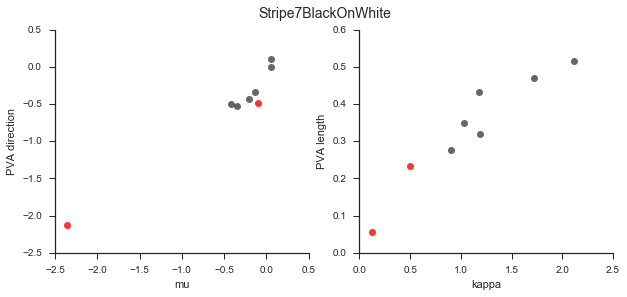

In [58]:
# Correlation between von Mieses fit and PVA
#Plot fit results
corrFig = plt.figure(figsize=(10,4))
corrFig.suptitle(sceneName,fontsize=14)

notFit = np.logical_and(vmfits[3,:]<=0.1, headingPVA[:,1]<0.5)

#correlation between mu and PVA direction
muax = corrFig.add_subplot(121)
muax.plot(vmfits[0,~notFit],headingPVA[~notFit,0],'ko',alpha=0.6)
muax.plot(vmfits[0,notFit],headingPVA[notFit,0],'ro',alpha=0.8)
muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
myAxisTheme(muax)

#correlation between kappa and PVA length
kapax = corrFig.add_subplot(122)
kapax.plot(vmfits[1,~notFit],headingPVA[~notFit,1],'ko',alpha=0.6)
kapax.plot(vmfits[1,notFit],headingPVA[notFit,1],'ro',alpha=0.8)
kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
myAxisTheme(kapax)

corrFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

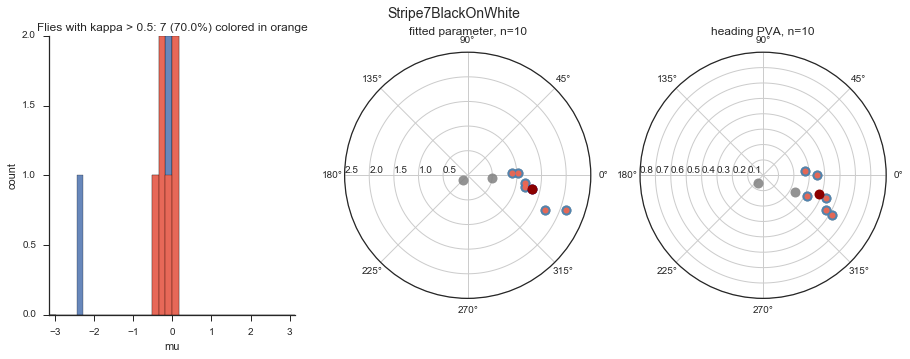

In [59]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

goodFit = np.logical_and(~notFit,~np.isnan(headingPVA[:,1]))

kappaTH = 0.5

slct = np.logical_and(vmfits[1,:]>kappaTH,goodFit)

bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(vmfits[0,~np.isnan(vmfits[0,:])],bins)
[n_slct,edg] = np.histogram(vmfits[0,slct],bins)
    
#Plot fit results
fixFig = plt.figure(figsize=(15,5))
fixFig.suptitle(sceneName,fontsize=14)

gs = gridspec.GridSpec(1,3,width_ratios=np.hstack((1,1.7,1.7)))

#histogram of fitted location (mu)
muax = fixFig.add_subplot(131)
muax.hist(vmfits[0,~np.isnan(vmfits[0,:])],bins,alpha=0.85)
muax.hist(vmfits[0,slct],bins,color='tomato',alpha=0.85)
muax.set_xlim(-np.pi, np.pi)
muax.set_xlabel('mu')
muax.set_ylabel('count')
muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[1,:]>kappaTH))+' ('+\
               str(round(100.0*sum(vmfits[1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
myAxisTheme(muax)

#polar plot of fitted location and shape parameter
ax = fixFig.add_subplot(132,projection='polar')
ax.plot(vmfits[0,:],vmfits[1,:],'o',markersize=10,color='grey',alpha=0.85)
ax.plot(vmfits[0,goodFit],vmfits[1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,goodFit],vmfits[1,goodFit], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
ax.plot(vmfits[0,slct],vmfits[1,slct],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(vmfits[0,slct],vmfits[1,slct], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
#ax.set_rlim(0,1)
ax.set_rlabel_position(180)
ax.set_title('fitted parameter, n='+str(numFlies))

#polar plot of PVA
ax = fixFig.add_subplot(133,projection='polar')
ax.plot(headingPVA[:,0],headingPVA[:,1],'o',markersize=10,color='grey',alpha=0.85)
ax.plot(headingPVA[goodFit,0],headingPVA[goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[:,0],headingPVA[:,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

ax.plot(headingPVA[slct,0],headingPVA[slct,1],'.',markersize=12,color='tomato',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[slct,0],headingPVA[slct,1], high=angleHigh, low=angleLow)
ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
ax.set_rlim(0,0.8)
ax.set_rlabel_position(180)
ax.set_title('heading PVA, n='+str(numFlies))

#fixFig.tight_layout()
fixFig.savefig(analysisDir + 'circStats/'  + genotype
               + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Use Rayleigh test on mean fixation location (on selected data)

In [60]:
# ...based on on fitted location parameter mu
fitSamples = len(vmfits[0,slct])
PVAdir, PVAlen = circmeanvec(vmfits[0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,fitSamples)

print('Test statistic z = ' + str(z))
print('Probability of test statistic p = ' + str(p))
if (p<0.001):
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.01): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.05): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
else:
    print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')

Test statistic z = 5.80464691971
Probability of test statistic p = 0.000525433486423
Reject H0 that sample is drawn from a uniform distribution (p<0.001).
Mean angle = -0.165 (-9.446 deg)


In [61]:
# ...based on PVA direction 
fitSamples = len(headingPVA[slct,0])
PVAdir, PVAlen = circmeanvec(headingPVA[slct,0],np.ones(fitSamples), high=angleHigh, low=angleLow)

[z,p] = RayleighTest(PVAlen,fitSamples)

print('Test statistic z = ' + str(z))
print('Probability of test statistic p = ' + str(p))
if (p<0.001):
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.01): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
elif (p<0.05): 
    print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
    print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
else:
    print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')

Test statistic z = 5.64504379895
Probability of test statistic p = 0.000738828413904
Reject H0 that sample is drawn from a uniform distribution (p<0.001).
Mean angle = -0.286 (-16.362 deg)


### Selection of data

In [62]:
print('Total number of flies measured: ' + str(numFlies))
print('Number of flies that walked for less than 20% of trial time: ' + str(fliesNotWalking) \
      + ' out of '+str(numFlies))
print('Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
      + ' out of '+str(numFlies-fliesNotWalking))
print('Number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
      +str(sum(vmfits[1,:]>kappaTH)) + ' out of '+str(numFlies-fliesNotWalking))
print('Number of *well* fitted distributions with concentration measure kappa > '+str(kappaTH)+' (orange marked dots): '\
      +str(sum(vmfits[1,goodFit]>kappaTH)) + ' out of '+str(sum(goodFit)))

Total number of flies measured: 10
Number of flies that walked for less than 20% of trial time: 2 out of 10
Number of walking flies for which von Mises was good fit: 6 out of 8
Number of fitted distributions with concentration measure kappa > 0.5: 7 out of 8
Number of *well* fitted distributions with concentration measure kappa > 0.5 (orange marked dots): 6 out of 6


## Find peaks in heading distribution

In [63]:
def findFixationPeak(N,flySignal):
    maxSignal = np.hstack((np.repeat(flySignal[0],N),flySignal,np.repeat(flySignal[-1],N)))
    maxSignal = np.convolve(maxSignal, np.ones((N,))/N, mode='same')
    maxSignal = maxSignal[N:-N]
    peak = np.where(maxSignal == np.max(maxSignal))[0]
    
    return peak

In [64]:
def findFullWidthHalfMax(y,peak,low):
    #find half maximum
    halfMax = np.median(y)#(y[peak]-y[low])/2.0 + y[low]
    # walk 'downhill' until below half max
    leftW = peak
    rightW = peak
    while(y[leftW]>halfMax):
        leftW = leftW-1
        if(leftW<0):
            leftW = len(y)-1
            
    while(y[rightW]>halfMax):
        rightW = rightW+1
        if(rightW>len(y)-1):
            rightW = 0
        
    return [leftW,rightW]

In [65]:
fullBins = 36
peaks_fullGamma = np.nan*np.ones((numFlies,2))
FWHM_fullGamma = np.nan*np.ones((numFlies))
densityFlag = True

print('\n'+sceneName+'\n')

for fly in range(numFlies):

    #print(flyIDs[fly])

    querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
    gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

    moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()

    if sum(moving)<=0.2*len(moving):
        continue

    histRange = (-np.pi, np.pi)
    nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=fullBins)
    if densityFlag:
        normFactor = nhead.sum()
    else:
        normFactor = 1.0

    currFlySignal = nhead/normFactor
    fulledges = edges[:-1]+np.diff(edges)/2

    # find peak of heading:
    N=5
    peak = findFixationPeak(N,currFlySignal)
    low = findFixationPeak(N,-1*currFlySignal)
    peak = findFixationPeak(N,currFlySignal)
    peaks_fullGamma[fly,:] = [fulledges[peak],currFlySignal[peak]]

    #find FWHM
    [leftW, rightW] = findFullWidthHalfMax(currFlySignal,peak,low)

    FWHM = np.abs((fulledges[rightW]+np.pi)-(fulledges[leftW]+np.pi))

    FWHM_fullGamma[fly] = FWHM



Stripe7BlackOnWhite



In [66]:
try:
    mkdir(analysisDir + sep + 'peakAnalysis' + sep)
except OSError:
    print('Analysis directory already exists.')
    
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksLoc_fullGamma.csv', peaks_fullGamma[:,0].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='BlackOnWhiteStripe', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksSize_fullGamma.csv', peaks_fullGamma[:,1].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='BlackOnWhiteStripe', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'FWHM_fullGamma.csv', FWHM_fullGamma.T,
           fmt="%s", delimiter=',', newline='\n',
           header='BlackOnWhiteStripe', footer='', comments='# ')

Analysis directory already exists.


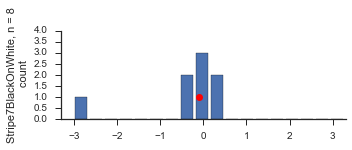

In [67]:
wherePeaksFig = plt.figure(figsize=(5,2))
histRange = (-np.pi, np.pi)
fullHistBins = 18


scenePlt = wherePeaksFig.add_subplot(1,1,1)
nhead, edges = np.histogram(peaks_fullGamma[~np.isnan(peaks_fullGamma[:,0]),0],range=histRange,bins=fullHistBins)
scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
nanMask = ~np.isnan(peaks_fullGamma[:,0])
meanx = np.arctan2(np.median(np.sin(peaks_fullGamma[nanMask,0])),np.median(np.cos(peaks_fullGamma[nanMask,0])));
scenePlt.plot(meanx,1,'ro')
sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[:,0]))))
scenePlt.set_ylabel(sceneName+', n = '+sampleSize+'\n count')
scenePlt.set_xlim(-np.pi*1.05,np.pi*1.05)
scenePlt.set_ylim(0,4)
myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + 'peakAnalysis' + sep + genotypeSex + '_peakLocHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

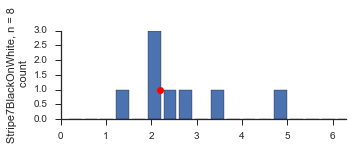

In [68]:
widthPeaksFig = plt.figure(figsize=(5,2))
histRange = (0,2*np.pi)
fullHistBins = 18
scenePlt = widthPeaksFig.add_subplot(1,1,1)
nhead, edges = np.histogram(FWHM_fullGamma[~np.isnan(FWHM_fullGamma[:])],range=histRange,bins=fullHistBins)
scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
nanMask = ~np.isnan(FWHM_fullGamma[:])
meanx = np.median(FWHM_fullGamma[nanMask])
scenePlt.plot(meanx,1,'ro')
sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[:,0]))))
scenePlt.set_ylabel(sceneName+', n = '+sampleSize+'\n count')
scenePlt.set_xlim(0,2*np.pi)
myAxisTheme(scenePlt)
widthPeaksFig.tight_layout()

widthPeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakWidthHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

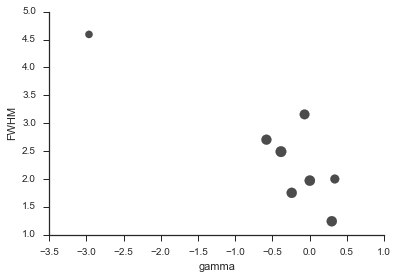

In [69]:
posVsWidth = plt.figure(figsize=(6,4))

posVsWidthPlt = posVsWidth.add_subplot(111)
colcode = ['black']
posVsWidthPlt.scatter(peaks_fullGamma[:,0]+0.1*np.random.rand(len(peaks_fullGamma[:,0])),
                      FWHM_fullGamma[:]+0.1*np.random.rand(len(peaks_fullGamma[:,0])),
                      c=colcode,s=1000*peaks_fullGamma[:,1],alpha=0.7)
#posVsWidthPlt.legend(sceneName,loc=9)
posVsWidthPlt.set_xlabel('gamma')
posVsWidthPlt.set_ylabel('FWHM')
myAxisTheme(posVsWidthPlt)

posVsWidth.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakPosVsWidthPeak_n'+str(numFlies)+'.pdf', format = 'pdf')

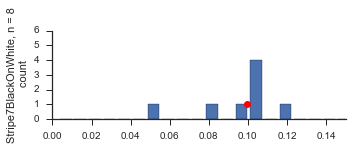

In [70]:
wherePeaksFig = plt.figure(figsize=(5,2))
maxSize = 0.15
histRange = (0,maxSize)
fullHistBins = 20
scenePlt = wherePeaksFig.add_subplot(1,1,1)
nhead, edges = np.histogram(peaks_fullGamma[~np.isnan(peaks_fullGamma[:,1]),1],range=histRange,bins=fullHistBins)
scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=0.8*maxSize/fullHistBins)
nanMask = ~np.isnan(peaks_fullGamma[:,1])
meanx = np.median(peaks_fullGamma[nanMask,1])
scenePlt.plot(meanx,1,'ro')
sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[:,0]))))
scenePlt.set_ylabel(sceneName+', n = '+sampleSize+'\n count')
scenePlt.set_xlim(0,maxSize)
scenePlt.set_ylim(0,6)
myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakHeightHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')